In [1]:
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/QCG Project"  # <<-- update this if folder name different
train_data = f"{base_path}/card.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, fbeta_score

In [3]:
df = pd.read_csv(train_data)
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,94.689486,0.212096,2.379196,1,0,0,0,0
1,2.148094,3.631258,0.867552,1,1,0,1,0
2,8.201513,0.196793,0.568646,1,0,0,1,0
3,1.813192,0.613588,0.749469,0,1,0,1,0
4,26.211924,4.871637,1.610984,1,0,1,1,0


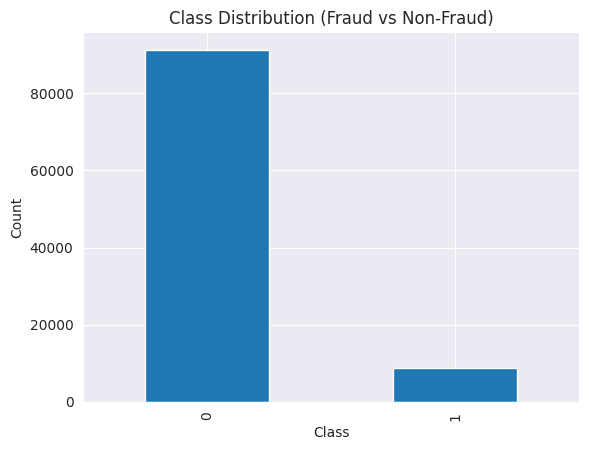

fraud
0    91260
1     8740
Name: count, dtype: int64
fraud
0    0.9126
1    0.0874
Name: count, dtype: float64


In [4]:
fraud_counts = df["fraud"].value_counts()

plt.figure()
fraud_counts.plot(kind="bar")
plt.title("Class Distribution (Fraud vs Non-Fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

print(fraud_counts)
print(fraud_counts / len(df))

In [5]:
missing = df.isna().sum()
missing

,0
distance_from_home,0
distance_from_last_transaction,0
ratio_to_median_purchase_price,0
repeat_retailer,0
used_chip,0
used_pin_number,0
online_order,0
fraud,0


In [6]:
df.duplicated().sum()


np.int64(0)

In [7]:
binary_cols = [
    "repeat_retailer",
    "used_chip",
    "used_pin_number",
    "online_order"
]
continuous_cols = [
    "distance_from_home",
    "distance_from_last_transaction",
    "ratio_to_median_purchase_price"
]



In [8]:
df[continuous_cols].skew()

,0
distance_from_home,18.329811
distance_from_last_transaction,76.152543
ratio_to_median_purchase_price,8.044507


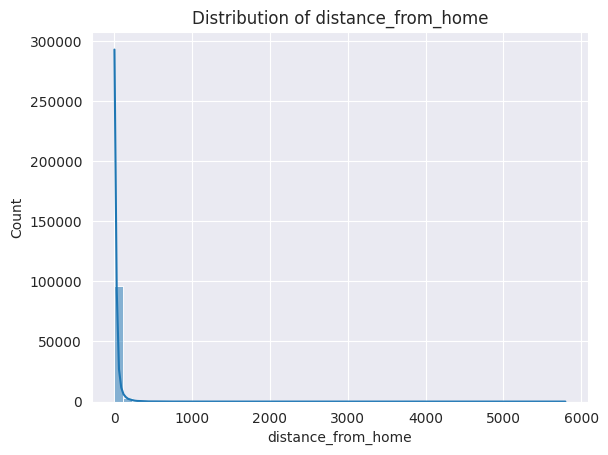

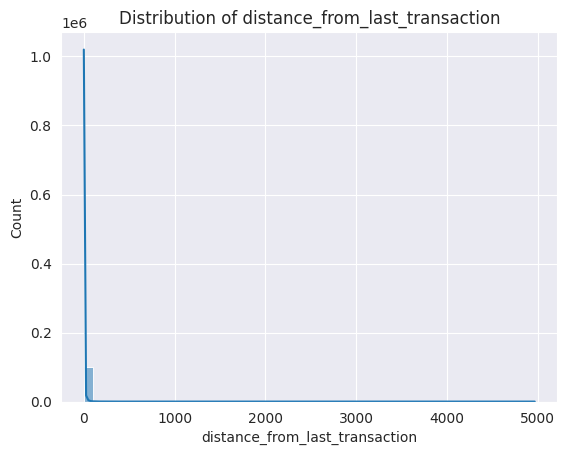

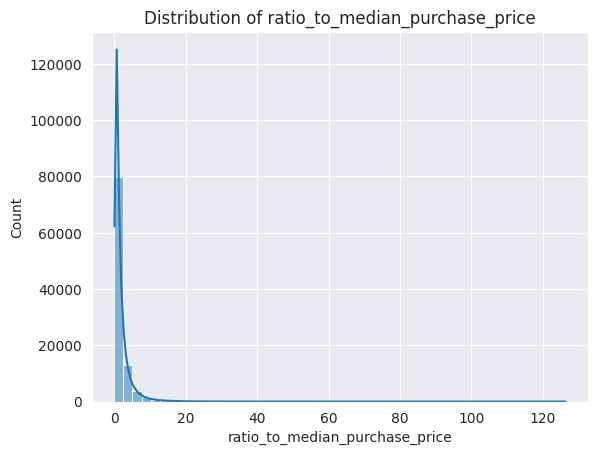

In [9]:
for col in continuous_cols:
    plt.figure()
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

In [10]:
X = df.drop("fraud", axis=1)
y = df["fraud"].astype(int)
print("Fraud ratio:", y.mean())


Fraud ratio: 0.0874


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [12]:
# IQR-based outlier removal (train only)
Q1 = X_train[continuous_cols].quantile(0.25)
Q3 = X_train[continuous_cols].quantile(0.75)
IQR = Q3 - Q1

mask = ~(
    (X_train[continuous_cols] < (Q1 - 1.5 * IQR)) |
    (X_train[continuous_cols] > (Q3 + 1.5 * IQR))
).any(axis=1)

X_train_clean = X_train.loc[mask].copy()
y_train_clean = y_train.loc[mask].copy()

print("Train size before outlier removal:", len(X_train))
print("Train size after outlier removal :", len(X_train_clean))


Train size before outlier removal: 80000
Train size after outlier removal : 57507


In [13]:
pt = PowerTransformer(method="yeo-johnson", standardize=False)

X_train_trf = X_train_clean.copy()
X_test_trf  = X_test.copy()

X_train_trf[continuous_cols] = pt.fit_transform(
    X_train_clean[continuous_cols]
)

X_test_trf[continuous_cols] = pt.transform(
    X_test[continuous_cols]
)

In [14]:
scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))

X_train_cont_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_trf[continuous_cols]),
    columns=continuous_cols,
    index=X_train_trf.index
)

X_test_cont_scaled = pd.DataFrame(
    scaler.transform(X_test_trf[continuous_cols]),
    columns=continuous_cols,
    index=X_test_trf.index
)


In [15]:
X_train_bin = X_train_trf[binary_cols]
X_test_bin  = X_test_trf[binary_cols]

X_train_scaled = pd.concat(
    [X_train_cont_scaled, X_train_bin],
    axis=1
)

X_test_scaled = pd.concat(
    [X_test_cont_scaled, X_test_bin],
    axis=1
)

In [16]:
mi = mutual_info_classif(X_train_scaled, y_train_clean, random_state=42)

mi_df = pd.DataFrame({
    "feature": X_train_scaled.columns,
    "mi_score": mi
}).sort_values(by="mi_score", ascending=False)

selected_features = mi_df.head(4)["feature"].tolist()

X_train_sel = X_train_scaled[selected_features].values
X_test_sel  = X_test_scaled[selected_features].values

y_train = y_train_clean

In [17]:
mi = mutual_info_classif(X_train_scaled, y_train_clean, random_state=42)

mi_df = pd.DataFrame({
    "feature": X_train_scaled.columns,
    "mi_score": mi
}).sort_values(by="mi_score", ascending=False)
mi_df


,feature,mi_score
2,ratio_to_median_purchase_price,0.055195
6,online_order,0.014267
3,repeat_retailer,0.009901
4,used_chip,0.004110
5,used_pin_number,0.001764
1,distance_from_last_transaction,0.000318
0,distance_from_home,0.000221


In [18]:
selected_features = mi_df.head(4)["feature"].tolist()

X_train_sel = X_train_scaled[selected_features].values
X_test_sel  = X_test_scaled[selected_features].values

y_train = y_train_clean

print("Selected features:", selected_features)

Selected features: ['ratio_to_median_purchase_price', 'online_order', 'repeat_retailer', 'used_chip']


In [19]:
lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

lr.fit(X_train_sel, y_train)

y_lr_proba = lr.predict_proba(X_test_sel)[:, 1]
y_lr_pred  = (y_lr_proba >= 0.5).astype(int)

auc_lr = roc_auc_score(y_test, y_lr_proba)
f2_lr  = fbeta_score(y_test, y_lr_pred, beta=2)


In [20]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train_sel, y_train)

y_rf_proba = rf.predict_proba(X_test_sel)[:, 1]
y_rf_pred  = (y_rf_proba >= 0.5).astype(int)

auc_rf = roc_auc_score(y_test, y_rf_proba)
f2_rf  = fbeta_score(y_test, y_rf_pred, beta=2)


In [21]:
nn = MLPClassifier(
    hidden_layer_sizes=(16,),
    activation="relu",
    max_iter=500,
    random_state=42
)

nn.fit(X_train_sel, y_train)

y_nn_proba = nn.predict_proba(X_test_sel)[:, 1]
y_nn_pred  = (y_nn_proba >= 0.5).astype(int)

auc_nn = roc_auc_score(y_test, y_nn_proba)
f2_nn  = fbeta_score(y_test, y_nn_pred, beta=2)


In [22]:
results = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Random Forest",
        "Neural Network"
    ],
    "AUC-ROC": [
        auc_lr,
        auc_rf,
        auc_nn
    ],
    "F2-score": [
        f2_lr,
        f2_rf,
        f2_nn
    ]
})

results


,Model,AUC-ROC,F2-score
0,Logistic Regression,0.867572,0.719389
1,Random Forest,0.871151,0.605629
2,Neural Network,0.865094,0.738591


In [23]:
!pip install qiskit qiskit-machine-learning qiskit-aer

In [24]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorSampler

from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.optimizers import COBYLA

from sklearn.metrics import roc_auc_score, fbeta_score

In [25]:
X_train_qml = X_train_sel.astype(float)
X_test_qml  = X_test_sel.astype(float)

y_train_qml = y_train.to_numpy().astype(int)
y_test_qml  = y_test.to_numpy().astype(int)


In [26]:
X_train_qml.shape

(57507, 4)

In [27]:
np.random.seed(42)
n_qml = 1000

idx = np.random.choice(len(X_train_qml), size=n_qml, replace=False)

X_train_qml_small = X_train_qml[idx]
y_train_qml_small = y_train_qml[idx]

num_features = X_train_qml_small.shape[1]  # should be 4


In [28]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

x = ParameterVector("x", num_features)
theta = ParameterVector("θ", 2 * num_features)

qc = QuantumCircuit(num_features)

# Feature map (angle encoding)
for i in range(num_features):
    qc.ry(x[i], i)

# Ring entanglement
for i in range(num_features - 1):
    qc.cx(i, i + 1)
qc.cx(num_features - 1, 0)

# Ansatz
for i in range(num_features):
    qc.ry(theta[2*i], i)
    qc.rz(theta[2*i + 1], i)

qc.draw("text")



┌──────────┐                      ┌───┐┌──────────┐┌──────────┐
q_0: ┤ Ry(x[0]) ├──■───────────────────┤ X ├┤ Ry(θ[0]) ├┤ Rz(θ[1]) ├
     ├──────────┤┌─┴─┐     ┌──────────┐└─┬─┘├──────────┤└──────────┘
q_1: ┤ Ry(x[1]) ├┤ X ├──■──┤ Ry(θ[2]) ├──┼──┤ Rz(θ[3]) ├────────────
     ├──────────┤└───┘┌─┴─┐└──────────┘  │  ├──────────┤┌──────────┐
q_2: ┤ Ry(x[2]) ├─────┤ X ├─────■────────┼──┤ Ry(θ[4]) ├┤ Rz(θ[5]) ├
     ├──────────┤     └───┘   ┌─┴─┐      │  ├──────────┤├──────────┤
q_3: ┤ Ry(x[3]) ├─────────────┤ X ├──────■──┤ Ry(θ[6]) ├┤ Rz(θ[7]) ├
     └──────────┘             └───┘         └──────────┘└──────────┘

In [29]:
from qiskit.primitives import StatevectorSampler
from qiskit_machine_learning.neural_networks import SamplerQNN

sampler = StatevectorSampler()

qnn = SamplerQNN(
    circuit=qc,
    input_params=x,
    weight_params=theta,
    sampler=sampler
)


In [30]:
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.optimizers import COBYLA

optimizer = COBYLA(maxiter=20)

classifier = NeuralNetworkClassifier(
    neural_network=qnn,
    optimizer=optimizer,
    loss="squared_error",
    initial_point=np.random.uniform(0, 2*np.pi, qnn.num_weights)
)

classifier.fit(X_train_qml_small, y_train_qml_small)

In [31]:
# Raw outputs (not probabilities)
qml_raw = classifier.predict(X_test_qml)

# Normalize to [0,1]
y_prob_qml = (qml_raw - qml_raw.min()) / (qml_raw.max() - qml_raw.min() + 1e-8)

auc_qml = roc_auc_score(y_test_qml, y_prob_qml)

threshold = 0.3
y_pred_qml = (y_prob_qml >= threshold).astype(int)

f2_qml = fbeta_score(y_test_qml, y_pred_qml, beta=2)

print("QML ROC-AUC:", auc_qml)
print("QML F2-score:", f2_qml)

QML ROC-AUC: 0.5675428159090806
QML F2-score: 0.40189826486726976
